<a href="https://colab.research.google.com/github/Vildend/tf-data-analysis-project1/blob/main/%D0%90%D0%BD%D0%B0%D0%BB%D0%B8%D0%B7%20%D0%B4%D0%B0%D0%BD%D0%BD%D1%8B%D1%85%20%D0%B2%20%D0%B8%D0%BD%D0%B4%D1%83%D1%81%D1%82%D1%80%D0%B8%D0%B8.%20%D0%9F%D1%80%D0%BE%D0%B5%D0%BA%D1%82%201.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Установим и подключим необходимые библиотеки.

In [ ]:
# !pip3 install psycopg2-binary
# https://www.psycopg.org/docs/install.html#quick-install

In [1]:
import psycopg2
from IPython.display import display, HTML
import warnings

import json
import pandas as pd
import plotly.express as px
from plotly import graph_objects as go
from plotly.subplots import make_subplots

# display(HTML("<style>.container { width:100% !important; }</style>"))
warnings.filterwarnings('ignore')
%matplotlib inline

Для того чтобы отслеживать, как выглядит путь клиента от знакомства с продуктом до его получения, и какие в нем есть проблемные места, аналитики часто строят воронки. Этот инструмент позволяет понять, сколько клиентов "теряется" на каждом из этапов процесса и сколько в итоге совершает целевое действие.

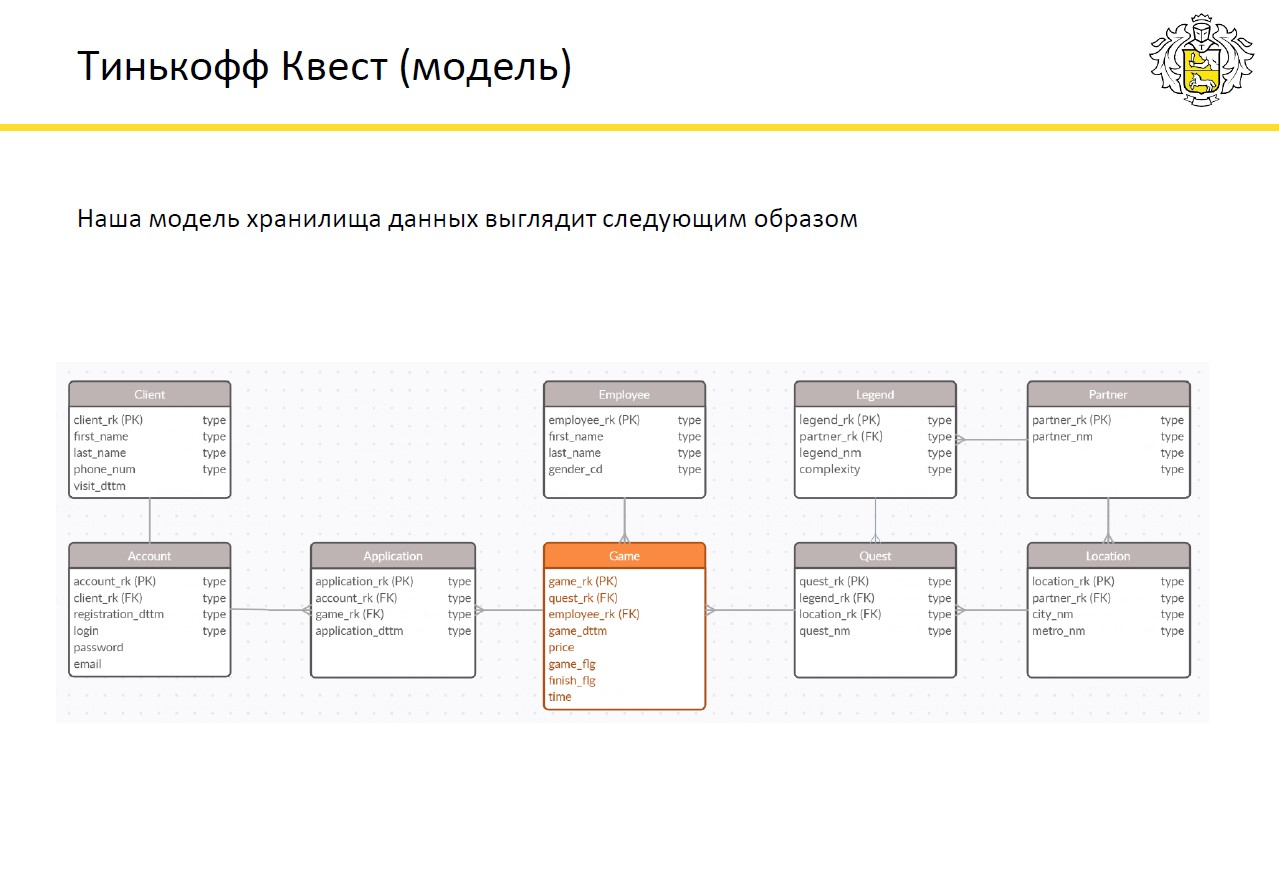

Перед вами схема данных проекта Тинькофф квест. Постройте воронку, которая показывала бы в динамике по неделям и месяцам, сколько клиентов посещает наш сайт, и какая доля из них регистрируется на нем \ подает заявку на игру \ по факту приходит на нее. Количество клиентов и конверсии необходимо изобразить на одном графике.

Для начала подключимся к базе данных.

In [ ]:
f = open('database_connect.json')
database_connect = json.load(f)
f.close()

conn = psycopg2.connect(
    host     = database_connect["host"],
    port     = database_connect["port"],
    database = database_connect["database"],
    user     = database_connect["user"],
    password = database_connect["password"],
)

Проверим успешное подключение к БД.

In [ ]:
ma_game = pd.read_sql("SELECT * FROM msu_analytics.game", conn)
ma_game.head()

,game_rk,quest_rk,employee_rk,game_dttm,price,game_flg,finish_flg,time
0,15,13,11,2022-11-17 02:13:10.970497,2701.92,0,0,00:00:00
1,79,31,3,2022-12-02 19:53:58.107147,1399.31,0,0,00:00:00
2,111,21,14,2022-11-22 09:31:30.506502,1349.32,0,0,00:00:00
3,127,15,7,2022-12-27 01:59:28.540922,1557.79,0,0,00:00:00
4,143,22,8,2022-12-30 10:39:51.834731,1880.07,0,0,00:00:00


Присвоим переменной <strong>df_month</strong> SQL запрос, в котором мы получаем необходимые для анализа суммы и конверсии по месяцам.

In [ ]:
df_month = pd.read_sql("""
    WITH counts_by_month AS (
        SELECT
            DATE_TRUNC('month', visit_dttm)::date AS month,
            COUNT(DISTINCT ma_client.client_rk) AS visits_count,
            COUNT(DISTINCT ma_account.account_rk) AS registrations_count,
            COUNT(DISTINCT ma_application.account_rk) AS applications_count,
            COUNT(DISTINCT ma_client.client_rk) FILTER(WHERE game_flg = 1) AS participants_count
        FROM msu_analytics.client AS ma_client
        LEFT JOIN msu_analytics.account AS ma_account USING(client_rk)
        LEFT JOIN msu_analytics.application AS ma_application USING(account_rk)
        LEFT JOIN msu_analytics.game AS ma_game USING(game_rk)
        GROUP BY month)

    SELECT
        month,
        visits_count,
        ROUND(visits_count / visits_count::decimal * 100, 2) AS visits_rate,
        registrations_count,
        ROUND(registrations_count / visits_count::decimal * 100, 2) AS registrations_rate,
        applications_count,
        ROUND(applications_count / visits_count::decimal * 100, 2) AS applications_rate,
        participants_count,
        ROUND(participants_count / visits_count::decimal * 100, 2) AS participants_rate
    FROM counts_by_month
    ORDER BY month
""", conn)
df_month

,month,visits_count,visits_rate,registrations_count,registrations_rate,applications_count,applications_rate,participants_count,participants_rate
0,2022-09-01,778,100.0,190,24.42,51,6.56,39,5.01
1,2022-10-01,843,100.0,217,25.74,65,7.71,56,6.64
2,2022-11-01,786,100.0,200,25.45,56,7.12,50,6.36
3,2022-12-01,805,100.0,196,24.35,57,7.08,33,4.10
4,2023-01-01,852,100.0,213,25.00,64,7.51,20,2.35
5,2023-02-01,32,100.0,8,25.00,0,0.00,0,0.00


Также переменной <strong>df_week</strong> присвоим тот же SQL запрос, но уже с группировкой по неделям.

In [ ]:
df_week = pd.read_sql("""
    WITH counts_by_week AS (
        SELECT
            DATE_TRUNC('week', visit_dttm)::date AS week,
            COUNT(distinct ma_client.client_rk) AS visits_count,
            COUNT(distinct ma_account.account_rk) AS registrations_count,
            COUNT(distinct ma_application.account_rk) AS applications_count,
            COUNT(distinct ma_client.client_rk) FILTER(where game_flg = 1) AS participants_count
        FROM msu_analytics.client AS ma_client
        LEFT JOIN msu_analytics.account AS ma_account USING(client_rk)
        LEFT JOIN msu_analytics.application AS ma_application USING(account_rk)
        LEFT JOIN msu_analytics.game AS ma_game USING(game_rk)
        GROUP BY week)
    SELECT
        week,
        visits_count,
        ROUND(visits_count / visits_count::decimal * 100, 2) AS visits_rate,
        registrations_count,
        ROUND(registrations_count / visits_count::decimal * 100, 2) AS registrations_rate,
        applications_count,
        ROUND(applications_count / visits_count::decimal * 100, 2) AS applications_rate,
        participants_count,
        ROUND(participants_count / visits_count::decimal * 100, 2) AS participants_rate
    FROM counts_by_week
    ORDER BY week
""", conn)
df_week.head()

,week,visits_count,visits_rate,registrations_count,registrations_rate,applications_count,applications_rate,participants_count,participants_rate
0,2022-08-29,111,100.0,32,28.83,7,6.31,5,4.50
1,2022-09-05,184,100.0,31,16.85,6,3.26,5,2.72
2,2022-09-12,167,100.0,43,25.75,16,9.58,8,4.79
3,2022-09-19,181,100.0,45,24.86,12,6.63,11,6.08
4,2022-09-26,195,100.0,59,30.26,17,8.72,17,8.72


На основе полученных данных построим воронку, которая покажет в динамике месяцам, сколько клиентов посещает сайт, и какая доля из них регистрируется на нем \ подает заявку на игру \ по факту приходит на нее.

In [ ]:
fig = go.Figure(
    data=go.Bar(
        name = 'Посещения на сайте',
        x = df_month.month,
        y = df_month.visits_count,
        hovertext = df_month.visits_count,
        marker=dict(color = 'rgb(158,202,225)', opacity=0.6),
    )
)

fig.add_trace(go.Scatter(
    name = 'конверсия из посещений в регистрацию',
    x = df_month.month,
    y = df_month.registrations_rate,
    text = df_month.registrations_count,
    yaxis="y2"
))
fig.add_trace(go.Scatter(
    name = 'конверсия из посещений в подачу заявки',
    x = df_month.month,
    y = df_month.applications_rate,
    text = df_month.applications_count,
    yaxis="y2"
))
fig.add_trace(go.Scatter(
    name = 'конверсия из посещений в посещение игры',
    x = df_month.month,
    y = df_month.participants_rate,
    text = df_month.participants_count,
    yaxis="y2"
))

fig.update_layout(
    legend=dict(orientation="h"),
    yaxis=dict(
        title=dict(text="Количество посещений"),
        side="left",
    ),
    yaxis2=dict(
        title=dict(text="Конверсии"),
        side="right",
        overlaying="y",
        tickmode="sync",
        range = [0, 100],
        ticksuffix='%'
    ),
    title_text='Воронка по месяцам',
    xaxis_title='Месяц',
)

fig.show()

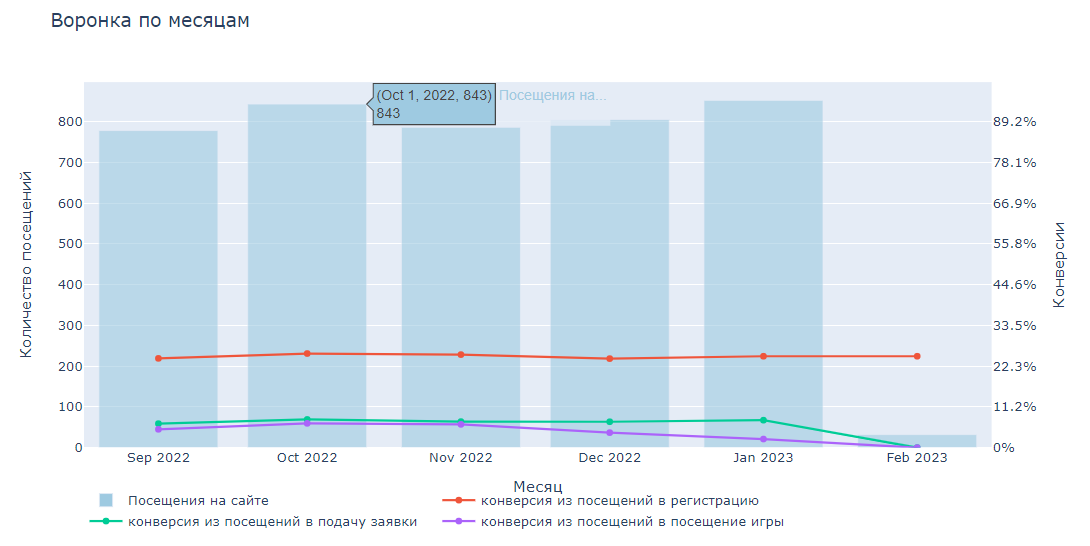

На месячном графике видим стабильное количество посещений в диапазоне с 770 до 850 человек. <br>
Конверсия регистраций и подач заявок держаться на одном уровне, 25% регистраций и 6-7% заявок соответственно. <br>
Что же касается конверсии посещения игр, то здесь, достигнув пика, мы видим постепенное снижение, начиная с октября 2022 года. <br>

Для более подробного анализа построим и посмотрим на недельный график.

In [ ]:
fig = go.Figure(
    data=go.Bar(
        name = 'Посещения на сайте',
        x = df_week.week,
        y = df_week.visits_count,
        marker=dict(color = 'rgb(158,202,225)', opacity=0.6),
    )
)

fig.add_trace(go.Scatter(
    name = 'конверсия из посещений в регистрацию',
    x = df_week.week,
    y = df_week.registrations_rate,
    text = df_week.registrations_count,
    yaxis="y2"
))
fig.add_trace(go.Scatter(
    name = 'конверсия из посещений в подачу заявки',
    x = df_week.week,
    y = df_week.applications_rate,
    text = df_week.applications_count,
    yaxis="y2"
))
fig.add_trace(go.Scatter(
    name = 'конверсия из посещений в посещение игры',
    x = df_week.week,
    y = df_week.participants_rate,
    text = df_week.participants_count,
    yaxis="y2"
))

fig.update_layout(
    legend=dict(orientation="h"),
    yaxis=dict(
        title=dict(text="Количество посещений"),
        side="left",
    ),
    yaxis2=dict(
        title=dict(text="Конверсии"),
        side="right",
        overlaying="y",
        range = [0, 100],
        tickmode="sync",
        ticksuffix='%'
    ),
    title_text='Воронка по неделям',
    xaxis_title='Неделя',
)

fig.show()


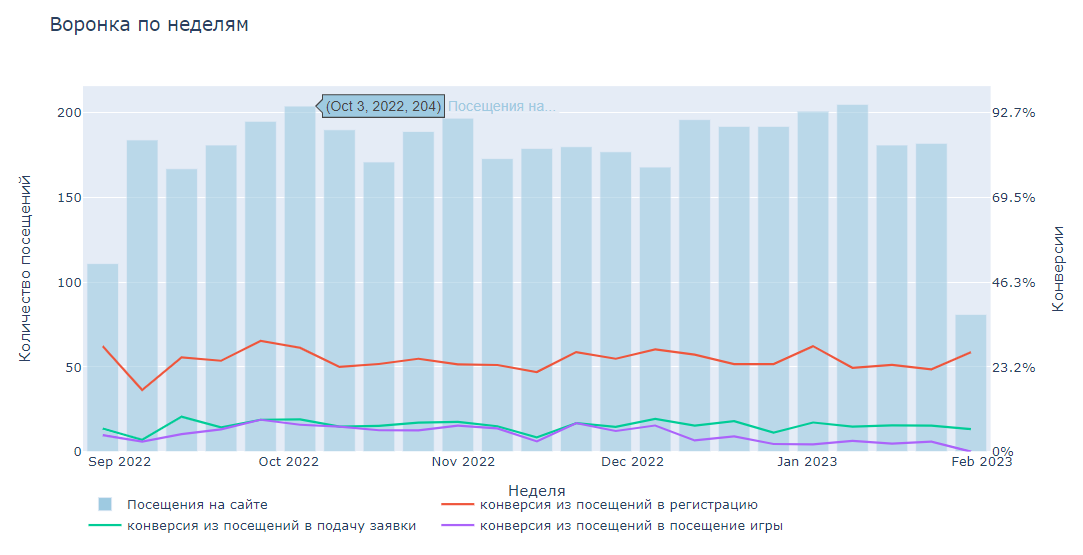

Здесь мы видим, что наиболее успешная неделя была с 26 сентября по 3 октября  2022 года. <br>
Также убеждаемся, что последний пик посещений игр мы достигли в ноябре 2022 года, после чего конверсия упала больше чем на 5%, в пике имея лишь почти 8%.

<strong>Какие выводы можно сделать исходя из построенной воронки, какие точки роста продукта вы видите?</strong>

Осенью высокая доля пользователей подававших заявки по итогу приходила на игры. Однако, начиная с зимы, посещение игр начало падать. Фактор сезонности или плохой организации квестов? Причину определить сложно из-за малого количества данных (5 месяцев).<br>

Количество посещающих сайт держится на одном уровне, а также ~75% посещающих сайт пользователей по итогу не регистрируются на сайте. Следовательно, можно сделать фокус на улучшении сайта и рекламе продукта.